In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rsnn.constants import FIRING_THRESHOLD, REFRACTORY_RESET
from rsnn.optim import compute_ck, Neuron, find_maximum_violation
from rsnn.rand import rand_f_times
from rsnn.utils import in_times_from_f_times

In [3]:
np.random.seed(42)

In [ ]:
neuron = Neuron(1000)

f_times = np.sort(np.random.uniform(0.0, 80.0, size=20))
f_times += np.arange(20)

in_times = np.random.uniform(0.0, 1000.0, size=1000)
in_channels = np.random.randint(0, 1000, size=1000)

neuron.init_learning(
    np.copy(f_times),
    np.copy(in_times),
    np.copy(in_channels),
    period=100.0,
)
res = neuron.learn(ftol=1e-9, rtol=1e-9, n_cstrs=1000)
assert res == 1
assert np.isclose(neuron.solver.primal_cost, 3.2043950176058726)

neuron.init_solver(
    np.copy(f_times),
    np.copy(in_times),
    np.copy(in_channels),
    period=100.0,
)
res = neuron.learn()
assert res == 1
assert np.isclose(neuron.solver.primal_cost, 3.2043950176058726)

2025-07-02 16:37:39.953' - DEBUG - Initialize the neuron for learning...
2025-07-02 16:37:40.007' - DEBUG - 20 new constraint(s) successfully added. The problem now has 20 constraints.
2025-07-02 16:37:40.008' - DEBUG - Neuron initialized successfully! The time axis has been decomposed into 1040 (potential) and 216 (potential derivative) intervals. The solver has been initialized with 20 constraints for 1000 variables.
2025-07-02 16:37:40.010' - DEBUG - DBFFD - Iteration 1: primal cost is 5.74011290542218 and dual cost is 4.357003534812719 (duality gap is -1.3831093706094606). Maximum violation is 0.0.
2025-07-02 16:37:40.011' - DEBUG - DBFFD - Iteration 2: primal cost is 4.525510350024686 and dual cost is 4.525510350024715 (duality gap is 2.842170943040401e-14). Maximum violation is 1.887379141862766e-14.
2025-07-02 16:37:40.012' - INFO - DBFFD - Feasible solution found in 2 iteration(s) with cost 4.525510350024686.
/Users/haguettaz/Desktop/RSNN/src/rsnn/optim.py:131: RuntimeWarning: 

# Input Signals

In [5]:
n_in_channels = 6
n_in_times = 20
f_thresh = FIRING_THRESHOLD
zmax, dzmin = 0.0, 1e-2
eps = 0.5
f_time = 5.0
in_times = np.random.uniform(0.0, f_time, size=n_in_times)
in_channels = (np.random.randint(0, n_in_channels, size=n_in_times))

In [6]:
start, length, ck0, ck1 = compute_ck(
    in_times,
    in_channels,
    n_in_channels,
    np.array([f_time, f_time-eps]),
    REFRACTORY_RESET
)

2025-07-02 15:56:32 - DEBUG - compute_ck - The time interval [0.0, 5.0) has been partitioned into 23 intervals.


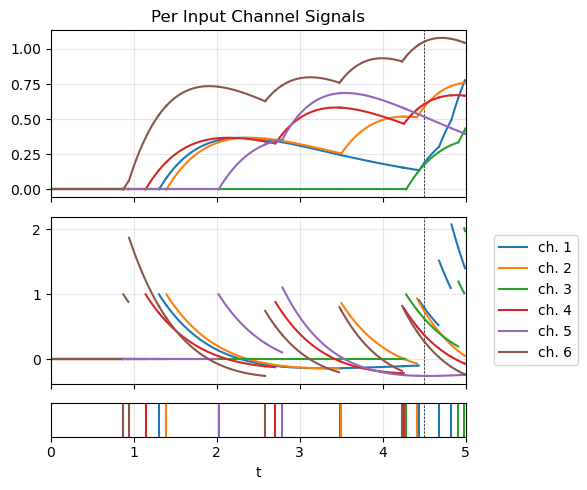

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(6, 5), sharex=True, height_ratios=(5, 5, 1))

for (in_time, in_channel) in zip(in_times, in_channels):
    axes[2].axvline(in_time, color=f'C{in_channel}')

for i in range(3):
    axes[i].axvline(f_time - eps, color=f'black', linewidth=0.5, linestyle='--', label='_nolegend_')

axes[2].set_xlabel('t')
axes[0].set_title('Per Input Channel Signals')
# axes[2].set_ylabel('Spikes')
axes[2].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, f_time)

for start_n, length_n, ck0_n, ck1_n in zip(start, length, ck0, ck1):
    # for k in range(neuron.n_in_channels):
    for k in range(n_in_channels):
        dt_vals = np.arange(0, length_n, 1e-2)
        t_vals = dt_vals + start_n
        y_vals = (ck0_n[k] + ck1_n[k] * dt_vals) * np.exp(-dt_vals)
        axes[0].plot(t_vals, y_vals, c=f"C{k}", linewidth=1.5)

        y_vals = (ck1_n[k] - ck0_n[k] - ck1_n[k] * dt_vals) * np.exp(-dt_vals)
        axes[1].plot(t_vals, y_vals, c=f"C{k}", linewidth=1.5)

axes[1].legend([f"ch. {k+1}" for k in range(n_in_channels)], bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)

plt.tight_layout()
plt.show()

# Iterative Constraint Refinement

In [8]:
def plot_tvc(ax, tc, vc):
    ax.axvline(
        tc,
        color="C1",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
        label=rf"$t_c={tc:.2f}$",
    )
    ax.scatter(tc, vc, color="C1", s=30)
    ax.legend()

def plot_z_template(neuron, ax, f_time, eps, f_thresh, zmax):
    for start, length, c0, c1 in zip(
        neuron.z_start, neuron.z_length, neuron.z_c0, neuron.z_c1
    ):
        dt_vals = np.arange(0, length, 1e-3)
        t_vals = dt_vals + start
        y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
        ax.plot(t_vals, y_vals, linewidth=1.5, c="C0", label="__nolegend_")

    ax.plot(
        np.array([0, f_time - eps]),
        np.full(2,zmax),
        color="C3",
        label="__nolegend_",
    )
    ax.plot(
        np.array([f_time - eps, f_time]),
        np.full(2,f_thresh),
        color="C3",
        label="__nolegend_",
    )

def plot_dz_template(neuron, ax, f_time, eps, dzmin):
    for start, length, c0, c1 in zip(
        neuron.dz_start, neuron.dz_length, neuron.dz_c0, neuron.dz_c1
    ):
        dt_vals = np.arange(0, length, 1e-3)
        t_vals = dt_vals + start
        y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
        ax.plot(t_vals, -y_vals, linewidth=1.5, c="C0", label="__nolegend_")

    ax.plot(
        np.array([f_time - eps, f_time]),
        np.full(2,dzmin),
        color="C3",
        label="__nolegend_",
    )

In [9]:
n_in_channels = 20
n_in_times = 25
f_thresh = 1.0
zmax, dzmin = 0.0, 0.5
eps = 0.5
period = 10.0
f_time = 0.0
in_times = np.random.uniform(0.0, period, size=n_in_times)
in_channels = (np.random.randint(0, n_in_channels, size=n_in_times))

2025-07-02 15:56:33 - DEBUG - init_solver - Firing times: [0.]
2025-07-02 15:56:33 - DEBUG - init_solver - before: [ 9.5 10. ]
2025-07-02 15:56:33 - DEBUG - compute_ck - The time interval [0.0, 10.0) has been partitioned into 28 intervals.
2025-07-02 15:56:33 - DEBUG - init_solver - after: [ 9.5 10. ]
2025-07-02 15:56:33 - DEBUG - add_constraints - A=array([[-0.16367094, -0.0627409 , -0.23805838, -0.        , -0.17129915,
        -0.002229  , -0.        , -0.01045036, -0.19810584, -0.4006398 ,
        -0.        , -0.00053411, -0.        , -0.18129551, -0.34921325,
        -0.        , -0.23555321, -0.1510935 , -0.        , -0.00416477]]), b=array([-1.0000454])
2025-07-02 15:56:33 - DEBUG - add_constraints - Added 1 new constraints.


TypeError: 'float' object cannot be interpreted as an integer

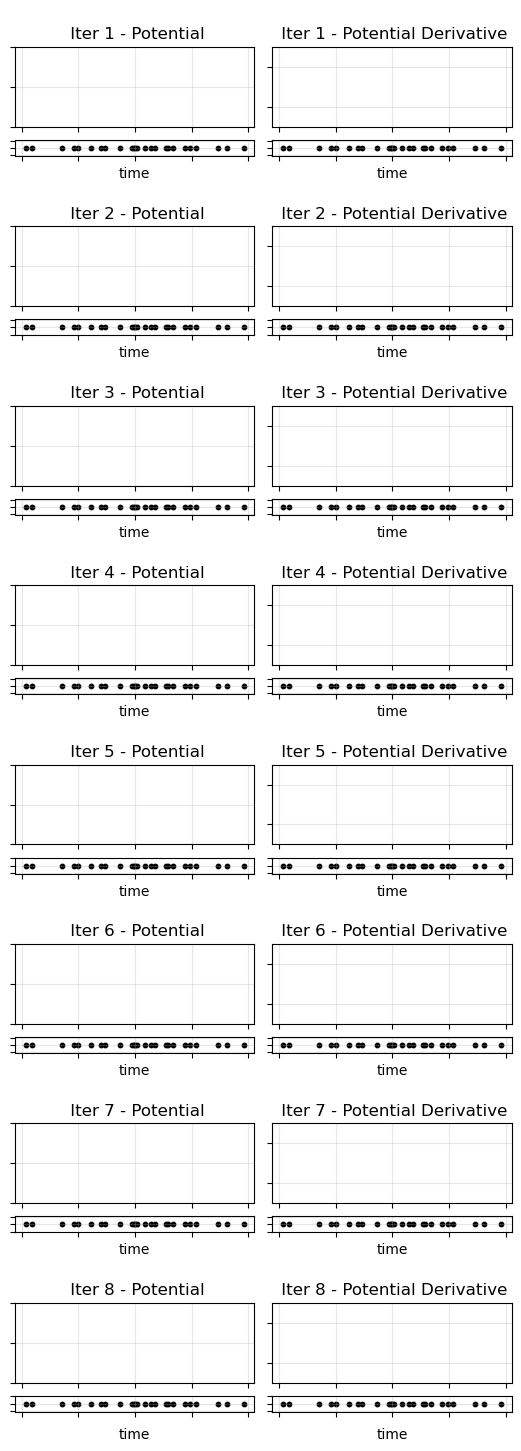

In [10]:
neuron = Neuron()
feas_tol, conv_tol = 1e-2, 1e-12
n_iter = 8

neuron.init_solver(
    np.array([f_time]),
    in_times,
    in_channels,
    period=period,
    eps=eps,
    zmax=zmax,
    dzmin=dzmin,
    f_thresh=f_thresh,
)

fig, axes = plt.subplots(
    2 * n_iter,
    2,
    figsize=(5.1, 1.8 * (n_iter)),
    sharex=True,
    height_ratios=(1, 0.2) * n_iter,
    layout="constrained",
    gridspec_kw={"hspace": 0.07, "wspace": 0.05},
)

# axes[-1][0].set_xlim(0, 10.0)

# axes[0][1].set_title("Potential Derivative")
# axes[-1][1].set_xlim(0, 10.0)

for i in range(n_iter):
    axes[2*i][0].set_title(f"\n Iter {i+1} - Potential")
    axes[2*i][1].set_title(f"\n Iter {i+1} - Potential Derivative")
    axes[2*i][0].grid(True, alpha=0.3)
    axes[2*i][1].grid(True, alpha=0.3)
    axes[2*i][0].set_ylim(-2, 2)
    axes[2*i][1].set_ylim(-1, 3.0)
    axes[2*i][0].set_xticklabels([])
    axes[2*i][0].set_yticklabels([])
    axes[2*i][1].set_xticklabels([])
    axes[2*i][1].set_yticklabels([])

    axes[2*i+1][0].grid(True, alpha=0.3)
    axes[2*i+1][1].grid(True, alpha=0.3)
    axes[2*i+1][0].set_xticklabels([])
    axes[2*i+1][0].set_yticklabels([])
    axes[2*i+1][1].set_xticklabels([])
    axes[2*i+1][1].set_yticklabels([])

    axes[2*i+1][0].set_xlabel("time")
    axes[2*i+1][1].set_xlabel("time")

    axes[2*i+1][0].scatter(in_times, np.zeros_like(in_times), s=10, color="black", label="_nolegend_")
    axes[2*i+1][1].scatter(in_times, np.zeros_like(in_times), s=10, color="black", label="_nolegend_")

for i in range(n_iter):
    res_dcd = neuron.solver.dbffd(feas_tol, conv_tol)
    if res_dcd == 1:
        neuron.z_c0 = (
            np.inner(neuron.z_ck0[:, :-1], neuron.solver.x) + neuron.z_ck0[:, -1]
        )
        neuron.z_c1 = (
            np.inner(neuron.z_ck1[:, :-1], neuron.solver.x) + neuron.z_ck1[:, -1]
        )
        plot_z_template(neuron, axes[2*i][0], period, eps, f_thresh, zmax)
        
        neuron.dz_c0 = (
            np.inner(neuron.dz_ck0[:, :-1], neuron.solver.x) + neuron.dz_ck0[:, -1]
        )
        neuron.dz_c1 = (
            np.inner(neuron.dz_ck1[:, :-1], neuron.solver.x) + neuron.dz_ck1[:, -1]
        )
        plot_dz_template(neuron, axes[2*i][1], period, eps, dzmin)

        z_imax, z_vmax, z_dtmax = find_maximum_violation(
            neuron.z_c0, neuron.z_c1, neuron.z_length, neuron.z_lim
        )

        dz_imax, dz_vmax, dz_dtmax = find_maximum_violation(
            neuron.dz_c0, neuron.dz_c1, neuron.dz_length, neuron.dz_lim
        )

        if z_vmax <= feas_tol and dz_vmax <= feas_tol:
            print(f"Optimal solution found in {i+1} iterations.")
            break
        else:
            if z_vmax > dz_vmax:
                neuron.solver.add_constraint(
                    (neuron.z_ck0[z_imax, :-1] + z_dtmax * neuron.z_ck1[z_imax, :-1])
                    * np.exp(-z_dtmax),
                    neuron.z_lim[z_imax]
                    - (neuron.z_ck0[z_imax, -1] + z_dtmax * neuron.z_ck1[z_imax, -1])
                    * np.exp(-z_dtmax),
                )
                plot_tvc(
                    axes[2*i][0],
                    neuron.z_start[z_imax] + z_dtmax,
                    z_vmax + neuron.z_lim[z_imax],
                )

            else:
                neuron.solver.add_constraint(
                    (
                        neuron.dz_ck0[dz_imax, :-1]
                        + dz_dtmax * neuron.dz_ck1[dz_imax, :-1]
                    )
                    * np.exp(-dz_dtmax),
                    neuron.dz_lim[dz_imax]
                    - (
                        neuron.dz_ck0[dz_imax, -1]
                        + dz_dtmax * neuron.dz_ck1[dz_imax, -1]
                    )
                    * np.exp(-dz_dtmax),
                )
                plot_tvc(
                    axes[2*i][1],
                    neuron.dz_start[dz_imax] + dz_dtmax,
                    -dz_vmax - neuron.dz_lim[dz_imax],
                )
    else:
        break

plt.legend()
# plt.tight_layout()
plt.show()

# `Neuron.learn()`

In [ ]:
# def plot_z_template(neuron, ax, f_time, eps, f_thresh, zmax):
#     for start, length, c0, c1 in zip(
#         neuron.z_start, neuron.z_length, neuron.z_c0, neuron.z_c1
#     ):
#         dt_vals = np.arange(0, length, 1e-2)
#         t_vals = dt_vals + start
#         y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
#         ax.plot(t_vals, y_vals, linewidth=1.5, c="C0", label="__nolegend_")

#     ax.plot(
#         np.array([0, f_time - eps]),
#         np.full(2,zmax),
#         color="C4",
#         label="__nolegend_",
#     )
#     ax.plot(
#         np.array([f_time - eps, f_time]),
#         np.full(2,f_thresh),
#         color="C4",
#         label="__nolegend_",
#     )

# def plot_dz_template(neuron, ax, f_time, eps, dzmin):
#     for start, length, c0, c1 in zip(
#         neuron.dz_start, neuron.dz_length, neuron.dz_c0, neuron.dz_c1
#     ):
#         dt_vals = np.arange(0, length, 1e-2)
#         t_vals = dt_vals + start
#         y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
#         ax.plot(t_vals, -y_vals, linewidth=1.5, c="C0", label="__nolegend_")

#     ax.plot(
#         np.array([f_time - eps, f_time]),
#         np.full(2,dzmin),
#         color="C4",
#         label="__nolegend_",
#     )

In [ ]:
n_neurons = 100
n_in_channels = 1000
period = 1000.0
f_rate = 0.5

f_times = rand_f_times(n_neurons, period, f_rate)
in_delays = np.random.uniform(0.0, 20.0, size=n_in_channels)
in_sources = np.random.randint(0, n_neurons, size=n_in_channels)

in_times = np.concatenate(
        [
            f_times[in_src] + in_delay
            for in_src, in_delay in zip(in_sources, in_delays)
        ]
    )
in_channels = np.concatenate(
    [
        np.full(f_times[in_src].size, in_channel, dtype=np.intp)
        for in_channel, in_src in enumerate(in_sources)
    ]
)
f_times_0 = np.sort((f_times[0]))
f_times_0 -= f_times_0[0]
f_times_0 = np.append(f_times_0, period)

In [ ]:
neuron = Neuron()

neuron.init_solver(
        np.copy(f_times_0[:-1]),
        in_times,
        in_channels,
        period=period,
        eps=0.2,
        zmax=0.0,
        dzmin=2.0,
    )
print("Starting learning...")
neuron.learn()

Starting learning...
Converged after 10 iterations
Feasible solution found with cost 0.5143628939230912.
Iteration 1: 272 constraints.
Converged after 10 iterations
Feasible solution found with cost 0.822030530954598.
Iteration 2: 273 constraints.
Converged after 8 iterations
Feasible solution found with cost 1.0495893624233101.
Iteration 3: 274 constraints.
Converged after 8 iterations
Feasible solution found with cost 1.4289862584817024.
Iteration 4: 275 constraints.
Converged after 9 iterations
Feasible solution found with cost 1.6780464557491928.
Iteration 5: 276 constraints.
Converged after 8 iterations
Feasible solution found with cost 1.7791325562547073.
Iteration 6: 277 constraints.
Converged after 8 iterations
Feasible solution found with cost 1.9721734811944258.
Iteration 7: 278 constraints.
Converged after 7 iterations
Feasible solution found with cost 2.2045306491367738.
Iteration 8: 279 constraints.
Converged after 8 iterations
Feasible solution found with cost 2.265695959

KeyboardInterrupt: 

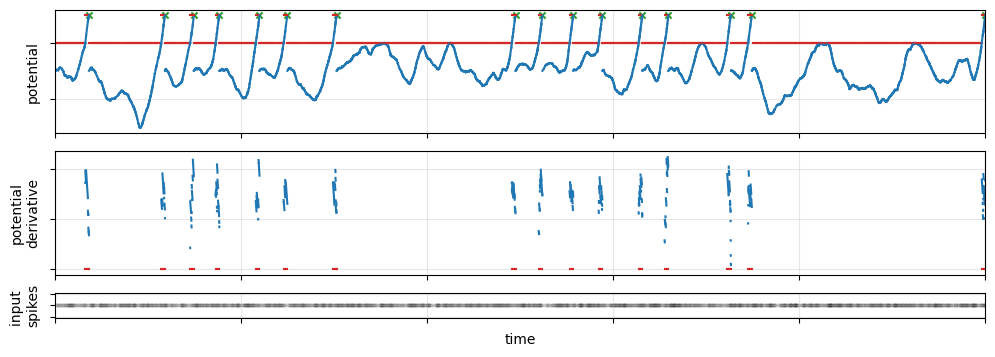

In [ ]:
fig, axes = plt.subplots(
    3,
    figsize=(12, 4),
    height_ratios=(1, 1, 0.2),
    sharex=True,
)

axes[0].set_xlim(f_times_0[0], f_times_0[-1])
axes[2].set_xlabel("time")
axes[0].set_ylabel("potential")
axes[1].set_ylabel("potential\nderivative")
axes[2].set_ylabel("input \nspikes")
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[2].grid(True, alpha=0.3)

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[2].set_xticklabels([])
axes[2].set_yticklabels([])

for start, length, c0, c1, lim in zip(
    neuron.z_start, neuron.z_length, neuron.z_c0, neuron.z_c1, neuron.z_lim
):
    dt_vals = np.arange(0, length, 1e-3)
    t_vals = dt_vals + start
    y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
    axes[0].plot(t_vals, y_vals, linewidth=1.5, c="C0", label="__nolegend_")
    axes[0].plot(t_vals, np.full_like(t_vals, lim), c="C3", label="__nolegend_")

for start, length, c0, c1, lim in zip(
    neuron.dz_start, neuron.dz_length, neuron.dz_c0, neuron.dz_c1, neuron.dz_lim
):
    dt_vals = np.arange(0, length, 1e-3)
    t_vals = dt_vals + start
    y_vals = (c0 + c1 * dt_vals) * np.exp(-dt_vals)
    axes[1].plot(t_vals, -y_vals, linewidth=1.5, c="C0", label="__nolegend_")
    axes[1].plot(t_vals, np.full_like(t_vals, -lim), c="C3", label="__nolegend_")

axes[0].scatter(f_times_0[1:], np.full_like(f_times_0[1:], FIRING_THRESHOLD), marker="x", s=20, c="C2")

axes[2].scatter(in_times % period, np.zeros_like(in_times), s=5, color="black", label="_nolegend_", alpha=0.03)

# plt.tight_layout()
plt.show()

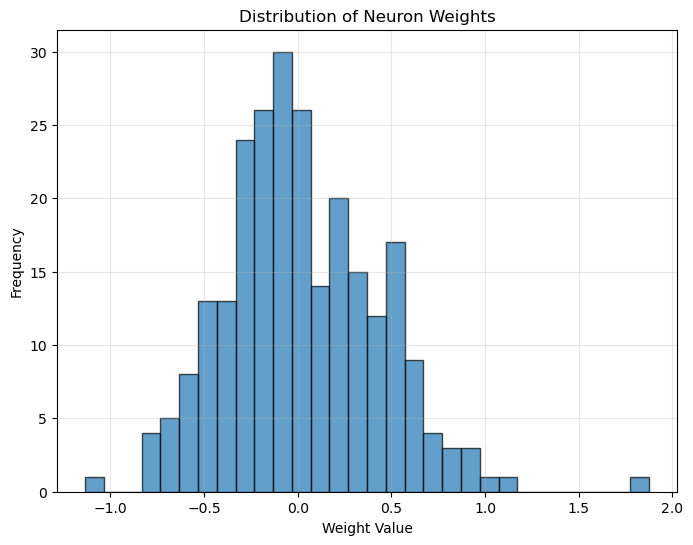

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(neuron.weight, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Distribution of Neuron Weights')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
n_in_channels = 500
n_in_times = 1000
f_thresh = 1.0
zmax, dzmin = 0.0, 1.0
eps = 0.5
period = 10.0
f_time = 0.0
in_times = np.random.uniform(0.0, period, size=n_in_times)
in_channels = (np.random.randint(0, n_in_channels, size=n_in_times))

neuron = optim.Neuron()
neuron.init_solver(
        np.array([f_time]),
        in_times,
        in_channels,
        period=period,
        eps=eps,
        zmax=zmax,
        dzmin=dzmin,
        f_thresh=f_thresh
    )
neuron.learn()

NameError: name 'optim' is not defined

# Determining the critical points

In [ ]:
in_coef = np.random.randn(2, 5, 10) / np.sqrt(10)  # shape (2, n_inputs, n_intervals)
ends = np.random.uniform(0, 5, size=5)  # shape (n_intervals,)
weights = np.random.randn(10)  # shape (n_inputs,)
zmax = 0.0  # some threshold value
coef = np.inner(in_coef, weights)  # shape (2, n_intervals)

imax, tmax, vmax = critical_potential(coef, ends, zmax)

fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

for i in range(5):
    t_vals = np.linspace(0, ends[i], 1000)
    y_vals = (coef[0, i] + coef[1, i] * t_vals) * np.exp(-t_vals)
    
    axes[i].plot(t_vals, y_vals, 'b-', linewidth=2)
    axes[i].axhline(y=zmax, color='r', linestyle='--', alpha=0.7, label=f'zmax={zmax}')
    axes[i].set_xlabel('t')
    axes[i].set_ylabel('Signal')
    axes[i].set_title(f'Interval {i+1}')
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_xlim(0, ends[i])
    axes[i].legend()

axes[imax].axvline(tmax, color='black', linestyle='--', label=f'tmax={tmax:.2f}, vmax={vmax:.2f}')
axes[imax].legend()

plt.tight_layout()
plt.show()

NameError: name 'critical_potential' is not defined

In [ ]:
coef[:, 2]
ts = np.clip(1 - coef[0,2] / coef[1,2], 0.0, ends[2])  # t = 1 - c0 / c1, the clipping also handles the case c1 = 0
vs = np.maximum(coef[0,2], (coef[0,2] + coef[1,2] * ts) * np.exp(-ts))
ts, vs

(np.float64(0.02153725776080251), np.float64(2.03236525539423))

In [ ]:
a = ((in_coef[0, imax] + tmax * in_coef[1, imax]) * np.exp(-tmax)).reshape(1, -1)
b = np.array([zmax])

In [ ]:
from dataclasses import dataclass


@dataclass
class InSpike:
    conn_id: int
    time: float


period = 100.0

n_f_times = 3
f_times = np.random.uniform(0, 100, size=n_f_times)
f_times = np.sort(f_times)
s0 = f_times[0]
# f_times = np.concatenate(
#     (np.array([f_times[-1] - period]), f_times, np.array([f_times[0] + period]))
# )
f_times -= s0
starts = np.append(f_times, period)
# ends = np.roll(f_times, -1)
# ends[-1] = period
f_times, starts

(array([ 0.        , 38.60756882, 50.88000478]),
 array([  0.        ,  38.60756882,  50.88000478, 100.        ]))

In [ ]:
# note: make sure in_spikes are in [0, period]
n_inputs = 6
n_in_spikes = 5
in_spikes = [
    InSpike(conn_id=np.random.randint(0, n_inputs), time=np.random.uniform(0, period))
    for _ in range(n_in_spikes)
] 
in_spikes.sort(key=lambda x: x.time)
in_ids = np.array([spike.conn_id for spike in in_spikes])
in_times = np.array([spike.time for spike in in_spikes])
# in_times = np.array([(spike.time - s0) % period for spike in in_spikes])

# find the interval indices for each input spike time
in_int = np.searchsorted(starts, in_times, side='right') - 1

in_times, starts

(array([ 2.6875488 ,  6.16243931, 53.41486702, 63.2614007 , 81.01977437]),
 array([  0.        ,  38.60756882,  50.88000478, 100.        ]))

In [ ]:
# correspond to the first interval, now needs to compute the subintervals
in_times[in_int == 0], in_ids[in_int == 0], starts[0], starts[1]

(array([2.6875488 , 6.16243931]),
 array([4, 1]),
 np.float64(0.0),
 np.float64(38.60756882432332))

In [ ]:
# we first consider only one interval (0, s] where s is the desired firing time
# assume the neuron receives n_in_spikes spikes from n_inputs inputs during the interval [0, s)
# there are n_in_spikes intervals to consider
# in_times and in_channels are the spike times and their corresponding input indices
n_in_times = 5
n_in_channels = 4
f_time = 42.0

in_times = np.sort(np.random.uniform(0, f_time, size=n_in_times))
in_channels = np.random.randint(0, n_in_channels, size=n_in_times)  # random input channels for the spikes

# we assume the n_in_times are sorted
# and we have 0 <= t_i < s for all t_i in in_times
in_coef = np.zeros((2, n_in_times, n_in_channels))  # shape (n_inputs, 2)
tmp_ind = np.arange(n_in_times)
in_coef[1, tmp_ind, in_channels[tmp_ind]] += 1.0
for n in range(1, n_in_times):
    dt = in_times[n] - in_times[n - 1]
    in_coef[0,n] += (in_coef[0, n-1] + in_coef[0, n-1] * dt) * np.exp(-dt)
    in_coef[1,n] += in_coef[1, n-1] * np.exp(-dt)

ends = np.diff(in_times, append=f_time)

In [ ]:
def init_in_coef(f_times:np.ndarray, in_times:np.ndarray, in_channels:np.ndarray, n_in_channels:np.intp) -> np.ndarray:
    # now, consider many firing times, each having its own subintervals
    # period = 100.0
    # n_f_times = 3
    # f_times = np.sort(np.random.uniform(0, period, size=n_f_times))
    # n_in_times = 5
    # n_in_channels = 4
    # in_times = np.sort(np.random.uniform(0, f_times[-1], size=n_in_times))
    # in_channels = np.random.randint(0, n_in_channels, size=n_in_times)  # random input channels for the spikes

    # assume ti < f_times[-1] for every ti in_times
    f_times = np.sort(f_times) # not necessary??
    in_times = np.sort(in_times)

    in_coef = np.zeros((2, in_times.size, n_in_channels))  # shape (n_inputs, 2)
    
    # compute the insertion positions of the firing times in the input times array
    ipos = np.searchsorted(in_times, f_times, side='left')  # number of intervals for each firing time
    ipos = np.append(ipos, in_times.size)
    ipos = np.unique(ipos)

    print(f"f_times: {f_times}")
    print(f"in_times: {in_times}")
    print(f"in_channels: {in_channels}")

    n0 = 0
    for nmax in ipos:
        in_coef[1, n0, in_channels[n0]] = 1.0
        for n in range(n0+1, nmax):
            dt = in_times[n] - in_times[n - 1]
            in_coef[0,n] += (in_coef[0, n-1] + in_coef[1, n-1] * dt) * np.exp(-dt)
            in_coef[1,n] += in_coef[1, n-1] * np.exp(-dt)
            in_coef[1, n, in_channels[n]] += 1.0
        n0 = nmax


    # n_inter depends on the number of input spikes but also on the template itself 
    # we need to return:
    #  in_coef, an array with shape (2, n_inter, n_channels)
    #  zmax, an array with shape (n_inter)
    #  ends, an array with shape (n_inter)
    # all are computed from the template

    # 

    return in_coef

In [ ]:
eps = 10.0
period = 100.0
n_f_times = 5
n_in_times = 10

f_times = np.sort(np.random.uniform(0, period, size=n_f_times))
in_times = np.sort(np.random.uniform(0, f_times[-1], size=n_in_times))
bf_times = f_times - eps
print(f"bf_times: {bf_times}")
print(f"f_times: {f_times}")
print(f"in_times: {in_times}")

bf_times: [-8.17821464 16.84273824 31.8841312  45.79219783 76.65783549]
f_times: [ 1.82178536 26.84273824 41.8841312  55.79219783 86.65783549]
in_times: [ 0.49178469  3.1180875   7.14583659 25.74915188 34.08348035 64.30034582
 67.57301143 77.44500688 78.55799656 81.21936233]


In [ ]:
i = 1 # ith interval
b_indices = np.searchsorted(in_times, bf_times, side='left') - 1
indices = np.searchsorted(in_times, f_times, side='left') - 1
print(f"the {i}th interval [{bf_times[i]}, {f_times[i]}) overlaps the states induced by all in_times between {in_times[b_indices[i]]} and {in_times[indices[i]]}")

the 1th interval [16.842738235978658, 26.842738235978658) overlaps the states induced by all in_times between 7.145836589856869 and 25.74915187873333


# Input Signals Via Piecewise Fading Linear Functions

In [ ]:
# another alternative is to compute the coefficients one firing window at a time
from typing import Tuple
import numpy as np


def compute_in_states(
    f_time: np.float32,
    bf_time: np.float32,
    in_times: np.ndarray,
    in_channels: np.ndarray,
    n_in_channels: np.intp,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the coefficients (c0nk and c1nk) defining the states of every input (indexed by k) for any time between 0 and f_time, on disjoint intervals (indexed by n).
    The intervals partition the time range [0, f_time] in n_intervals = in_times.size + 3 intervals from the following time markers:
    - 0.0, the start of the time range
    - bf_time, the time before firing (the beginning of the active region)
    - f_time, the firing time
    - in_times, the input spike times.
    The intervals are reconstructed from their start and length.
    The signal (c0nk + c1nk * dt) * exp(-dt) for 0 <= dt < length[n] then corresponds to 
    a) the kth input signal on the nth interval [start[n], start[n] + length[n]) if start[n] + length[n] < bf_time.
    b) the derivative of the kth input signal on the nth interval [start[n], start[n] + length[n]) if start[n] + length[n] < f_time and start[n] >= f_time.
    c) the kth input signal on the nth interval [start[n], start[n] + length[n]) if start[n] = f_time.

    Args:
        f_time (np.float32): _description_
        bf_time (np.float32): _description_
        in_times (np.ndarray): _description_
        in_channels (np.ndarray): _description_
        n_in_channels (np.intp): _description_

    Returns:
        np.ndarray: the coefficients defining the input signals by parts with shape (2, n_intervals, n_channels)
        np.ndarray: the times at which the intervals start with shape (n_intervals)
        np.ndarray: the lengths the intervals, with shape (n_intervals)
    """
    # Extract the in_times and in_channels that are valid, i.e., within the range [0, f_time)
    valid = (in_times >= 0.0) & (in_times < f_time)
    in_times = in_times[valid]
    in_channels = in_channels[valid]

    # Initialize the starts array
    starts = np.concatenate((in_times, np.array([0.0, f_time, bf_time])))

    # Initialize the coefficients array
    in_coef = np.zeros((2, starts.size, n_in_channels))
    in_coef[1, np.arange(in_times.size), in_channels] = 1.0

    # Sort the coefficients according to their starts
    sort_ids = np.argsort(starts)
    starts = starts[sort_ids]
    lengths = np.diff(starts, append=f_time)  # time differences = lengths of the intervals
    # ends = starts + lengths

    in_coef = in_coef[:, sort_ids, :]
    for n in range(starts.size - 1):
        in_coef[1, n + 1] += in_coef[1, n] * np.exp(-lengths[n])
        in_coef[0, n + 1] += (in_coef[0, n] + in_coef[1, n] * lengths[n]) * np.exp(-lengths[n])

    # The signal of interest on the active region is the (negative) derivative
    active = (starts >= bf_time) & (starts < f_time)
    in_coef[0, active] -= in_coef[1, active]  # (negative) derivative

    return in_coef, starts, lengths

In [ ]:
f_time = 100.0
n_in_times = 50
n_in_channels = 5

in_times = np.random.uniform(0, f_time, size=n_in_times)
in_channels = np.random.randint(0, n_in_channels, size=n_in_times)

In [ ]:
bf_time = f_time
in_coef, starts, durations = compute_in_states(f_time, bf_time, in_times, in_channels, n_in_channels)

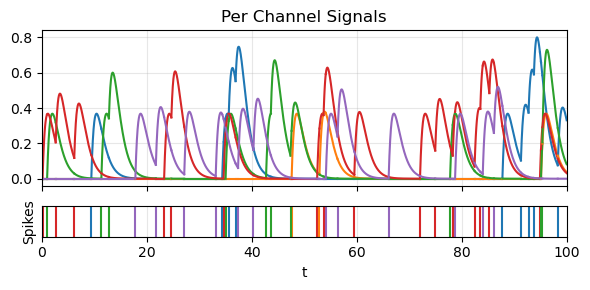

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(in_coef.shape[1]):
    for k in range(n_in_channels):
        dt_vals = np.arange(0, durations[n], 1e-2)
        t_vals = dt_vals + starts[n]
        y_vals = (in_coef[0, n, k] + in_coef[1, n, k] * dt_vals) * np.exp(-dt_vals)
        axes[0].plot(t_vals, y_vals, c=f"C{k}", linewidth=1.5)
        

for n in range(in_times.size):
    axes[1].axvline(in_times[n], color=f'C{in_channels[n]}')

axes[1].set_xlabel('t')
axes[0].set_title('Per Channel Signals')
axes[1].set_ylabel('Spikes')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100.0)
# axes[1].legend([f"ch. {k+1}" for k in range(n_in_channels)], bbox_to_anchor=(0.5, -1.55), loc='upper center', ncol=5)

plt.tight_layout()
plt.show()

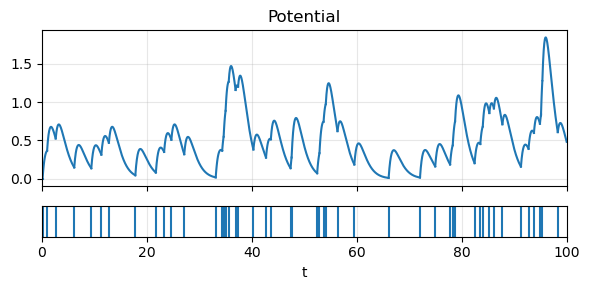

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(in_coef.shape[1]):
    dt_vals = np.arange(0, durations[n], 1e-2)
    t_vals = dt_vals + starts[n]
    y_vals = (np.sum(in_coef[0, n]) + np.sum(in_coef[1, n]) * dt_vals) * np.exp(-dt_vals)
    axes[0].plot(t_vals, y_vals, c="C0", linewidth=1.5)
        

for n in range(in_times.size):
    axes[1].axvline(in_times[n], color='C0')

axes[1].set_xlabel('t')
axes[0].set_title('Potential')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100.0)

plt.tight_layout()
plt.show()

In [ ]:
bf_time = 0.0
in_coef, starts, durations = compute_in_states(f_time, bf_time, in_times, in_channels, n_in_channels)

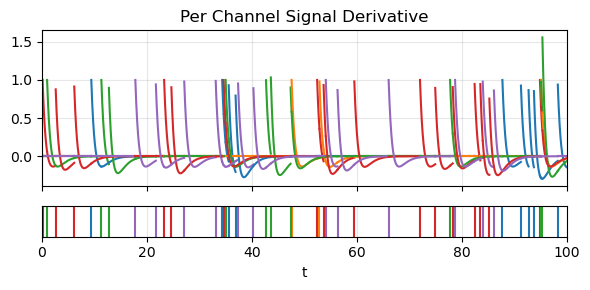

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(in_coef.shape[1]):
    for k in range(n_in_channels):
        dt_vals = np.arange(0, durations[n], 1e-2)
        t_vals = dt_vals + starts[n]
        y_vals = -(in_coef[0, n, k] + in_coef[1, n, k] * dt_vals) * np.exp(-dt_vals)
        axes[0].plot(t_vals, y_vals, c=f"C{k}", linewidth=1.5)
        

for n in range(in_times.size):
    axes[1].axvline(in_times[n], color=f'C{in_channels[n]}')

axes[1].set_xlabel('t')
axes[0].set_title('Per Channel Signal Derivative')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100.0)
# axes[0].legend([f"ch. {k+1}" for k in range(n_in_channels)], bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=5)

plt.tight_layout()
plt.show()

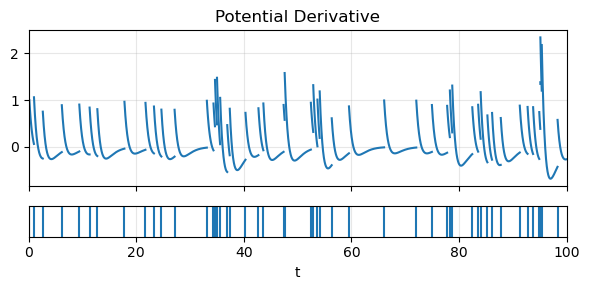

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(in_coef.shape[1]):
    dt_vals = np.arange(0, durations[n], 1e-2)
    t_vals = dt_vals + starts[n]
    y_vals = -(np.sum(in_coef[0, n]) + np.sum(in_coef[1, n]) * dt_vals) * np.exp(-dt_vals)
    axes[0].plot(t_vals, y_vals, c="C0", linewidth=1.5)
        

for n in range(in_times.size):
    axes[1].axvline(in_times[n], color='C0')

axes[1].set_xlabel('t')
axes[0].set_title('Potential Derivative')
# axes[1].set_ylabel('Spikes')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(0, 100.0)

plt.tight_layout()
plt.show()

In [ ]:
def mod(x, modulus, offset=0.0):
    """
    Compute the modulo operation with a given modulus and offset.
    """
    return x - modulus * np.floor((x - offset) / modulus)

# for n in n_f_times:
#     tmp_in_times = ((in_times % period) + period) % period

x = np.linspace(0, 5, 10)
y = mod(x, 5.0, offset=-1.0)
x, y

(array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
        2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ]),
 array([ 0.        ,  0.55555556,  1.11111111,  1.66666667,  2.22222222,
         2.77777778,  3.33333333,  3.88888889, -0.55555556,  0.        ]))

In [ ]:
period = 100.0
eps = 1.0

n_f_times = 5
n_in_times = 50
n_in_channels = 6

f_times = np.sort(np.random.uniform(0, period, size=n_f_times))
in_times = np.random.uniform(0, period, size=n_in_times)
in_channels = np.random.randint(0, n_in_channels, size=n_in_times)  # random input channels for the spikes


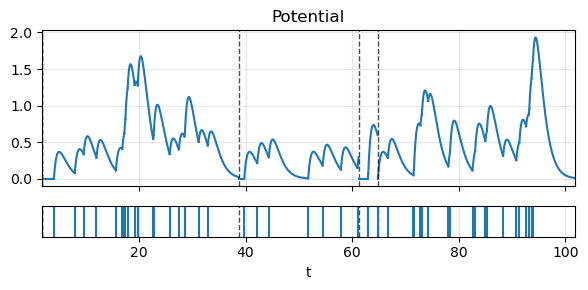

In [ ]:
# print(f"f_times: {f_times}")
# print(f"in_times: {in_times}")
# print(f"in_channels: {in_channels}")

fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, height_ratios=(5, 1))

for n in range(n_f_times):
    f_time = (f_times[n] - f_times[n - 1]) % period
    bf_time = f_time - eps
    in_coef, starts, durations = compute_in_states(
        f_time,
        f_time,
        (in_times - f_times[n - 1]) % period,
        in_channels,
        n_in_channels,
    )

    for m in range(in_coef.shape[1]):
        dt_vals = np.arange(0, durations[m], 1e-2)
        t_vals = dt_vals + starts[m] + f_times[n - 1]
        y_vals = (np.sum(in_coef[0, m]) + np.sum(in_coef[1, m]) * dt_vals) * np.exp(-dt_vals)
        axes[0].plot(t_vals, y_vals, c="C0", linewidth=1.5)

    axes[0].axvline(f_times[n], color='black', linestyle='--', linewidth=1.0, alpha=0.7)
    axes[1].axvline(f_times[n], color='black', linestyle='--', linewidth=1.0, alpha=0.7)
        
for m in range(in_times.size):
    axes[1].axvline((in_times[m] - f_times[0])%period + f_times[0], color='C0')

axes[1].set_xlabel('t')
axes[0].set_title('Potential')
axes[1].set_yticks([])
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[0].set_xlim(f_times[0], f_times[0] + period)

plt.tight_layout()
plt.show()

In [ ]:
in_times[3] = starts[1]
in_times, np.searchsorted(starts, in_times, side='right') - 1 # so that a new spike can be added exactly at the moment a firing occurs, otherwise, use side='left' for the opposite behavior


(array([71.33503425, 77.81319448, 15.01865438, 38.60756882, 49.52205263]),
 array([2, 2, 0, 1, 1]))

In [ ]:
# How to efficiently switch between in_coef and coef?
# coef should define the potential on the intervals (0, ends) or (starts, ends)
# they should be easily computed from in_coef and the weights
# we can probably 

array([  0.        ,  38.60756882,  50.88000478, 100.        ])

In [ ]:
coef 

In [ ]:
in_coef = np.random.randn(2, 0, 10) / np.sqrt(10)  # shape (2, n_inputs, n_intervals)
ends = np.random.uniform(0, 5, size=0)  # shape (n_intervals,)
weights = np.random.randn(10)  # shape (n_inputs,)
zmax = 0.0  # some threshold value
coef = np.inner(in_coef, weights)  # shape (2, n_intervals)

(imax, tmax, vmax) = critical_potential(in_coef, ends, weights, zmax)

TypeError: critical_potential() takes 3 positional arguments but 4 were given

In [ ]:
in_times = np.random.uniform(0, 5, size=10)
in_times.sort()
id = np.searchsorted(in_times, in_times[2], side='right')
id, in_times[id:], in_times

(np.int64(3),
 array([0.90826061, 1.37196686, 2.49940649, 2.5435063 , 2.67922178,
        3.34825177, 4.4945422 ]),
 array([0.06649748, 0.27871313, 0.41159789, 0.90826061, 1.37196686,
        2.49940649, 2.5435063 , 2.67922178, 3.34825177, 4.4945422 ]))

In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
weights = np.random.randn(1000)
lengths = np.random.uniform(0.1, 1.0, size=1000)

ids = np.argsort(starts)
starts = starts[ids]
lengths = lengths[ids]
weights = weights[ids]

103 μs ± 4.07 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
weights = np.random.randn(1000)
lengths = np.random.uniform(0.1, 1.0, size=1000)

54.1 μs ± 1.79 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
states = np.empty((1000), dtype=[('start', 'f4'), ('length', 'f4'), ('weight', 'f4')])
states["start"] = np.random.uniform(0, 5, size=1000)
states["weight"] = np.random.randn(1000)
states["length"] = np.random.uniform(0.1, 1.0, size=1000)
states.sort(order='start')

588 μs ± 14.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit 
states = np.empty((1000), dtype=[('start', 'f4'), ('length', 'f4'), ('weight', 'f4')])
states["start"] = np.random.uniform(0, 5, size=1000)
states["weight"] = np.random.randn(1000)
states["length"] = np.random.uniform(0.1, 1.0, size=1000)

60.5 μs ± 2.28 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
n_states = 10

starts = np.random.uniform(0, 5, size=n_states)
weights = np.random.randn(n_states)
lengths = np.random.uniform(0.1, 1.0, size=n_states)
print(starts)

ids = np.argsort(starts)
starts = starts[ids]
lengths = lengths[ids]
weights = weights[ids]
print(starts)

# remove all states with a start time < 2.0
id = np.searchsorted(starts, 2.0, side='left')
starts = starts[id:]
lengths = lengths[id:]
weights = weights[id:]
print(starts)

[2.63491607 2.48902886 3.16693173 4.71848624 3.85999523 3.20347066
 0.33640457 1.36461836 4.88385506 1.83646752]
[0.33640457 1.36461836 1.83646752 2.48902886 2.63491607 3.16693173
 3.20347066 3.85999523 4.71848624 4.88385506]
[2.48902886 2.63491607 3.16693173 3.20347066 3.85999523 4.71848624
 4.88385506]


In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
starts.sort()
weights = np.random.uniform(0.1, 1.0, size=1000)

59.6 μs ± 1.11 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
starts.sort()
weights = np.random.uniform(0.1, 1.0, size=1000)
starts = np.append(starts, -np.inf)
weights = np.append(weights, 0.0)
ids = np.argsort(starts)
starts = starts[ids]
weights = weights[ids]

79.2 μs ± 1.5 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
starts = np.random.uniform(0, 5, size=1000)
starts.sort()
weights = np.random.uniform(0.1, 1.0, size=1000)
starts = np.concatenate(([-np.inf], starts))
weights = np.concatenate(([0.0], weights))
# ids = np.argsort(starts)
# starts = starts[ids]
# weights = weights[ids]

62.9 μs ± 798 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
n_neurons = 100
r_f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
dist = np.concatenate([(r_f_times_n[np.newaxis, :] - f_times_n[:, np.newaxis]).reshape(-1) for (r_f_times_n, f_times_n) in zip(r_f_times, f_times)])
dist.sort()

18.7 ms ± 643 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit 
n_neurons = 100
r_f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
dist = np.concatenate([(r_f_times_n[np.newaxis, :] - f_times_n[:, np.newaxis]).flatten() for (r_f_times_n, f_times_n) in zip(r_f_times, f_times)])
dist.sort()

19 ms ± 173 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit 
n_neurons = 100
r_f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]
f_times = [np.random.uniform(0.0, 100.0, size=np.random.randint(0, 100)) for _ in range(n_neurons)]

1.27 ms ± 13.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
times_1 = np.arange(3)
times_2 = np.arange(50, step=10)
(times_1[np.newaxis, :] + times_2[:, np.newaxis]).reshape(-1)
# (times_1[:, np.newaxis] + times_2[np.newaxis, :]).reshape(-1)

array([ 0,  1,  2, 10, 11, 12, 20, 21, 22, 30, 31, 32, 40, 41, 42])

In [ ]:
times = np.array([])
np.full(4, 1.0 / (1.0 * times.size))

ZeroDivisionError: float division by zero